# 9장 CNN을 활용한 이미지 인식

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [2]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [2]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

### GPU 확인하기

In [4]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNN의 처리 개요

In [5]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)

# weight를 특수한 값으로
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [7]:
# 손글씨 숫자에 3번 합성곱 처리를 함
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

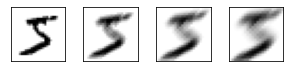

In [8]:
# 결과 화면 출력

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 파이토치에서 CNN을 구현하는 방법

### nn.Conv2d 와 nn.MaxPool2d

In [9]:
# CNN 모델 전반 부분, 레이어 함수 정의

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [10]:
# conv1 확인
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [11]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]

# weight[0]의 shape과 값 확인
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.1114 -0.1836 -0.0973]
  [ 0.0944  0.0068  0.056 ]
  [ 0.0835 -0.1831 -0.0345]]

 [[-0.048   0.0686  0.1465]
  [-0.1195 -0.1628 -0.0934]
  [ 0.1899 -0.016   0.1087]]

 [[ 0.0044  0.0332  0.1438]
  [-0.1482  0.0268 -0.0617]
  [-0.0788 -0.1237 -0.0932]]]


In [12]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [13]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [14]:
# 각 변수의 shape 확인

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [15]:
# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [16]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [17]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.5 공통 함수 사용하기

### eval_loss(손실 계산)

In [18]:
# 손실 계산용
def eval_loss(loader, device, net, criterion):
  
    # 데이터로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss

### fit(학습)

In [19]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history(학습 로그)

In [20]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

### show_images_labels(예측 결과 표시)

In [21]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed(난수 초기화)

In [22]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


## 9.6 데이터 준비

In [23]:
# Transforms의 정의

# transformer1 1계 텐서화

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 정규화만 실시

# 검증 데이터용 : 정규화만 실시
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [24]:
# 데이터 취득용 함수 datasets

data_root = './data'

# 훈련 데이터셋 (1계 텐서 버전)
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 검증 데이터셋 (1계 텐서 버전)
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 훈련 데이터셋 (3계 텐서 버전)
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 검증 데이터셋 (3계 텐서 버전)
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 데이터셋 확인

In [25]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [26]:
# 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [27]:
# train_loader1에서 한 세트 가져오기
for images1, labels1 in train_loader1:
    break

# train_loader2에서 한 세트 가져오기
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


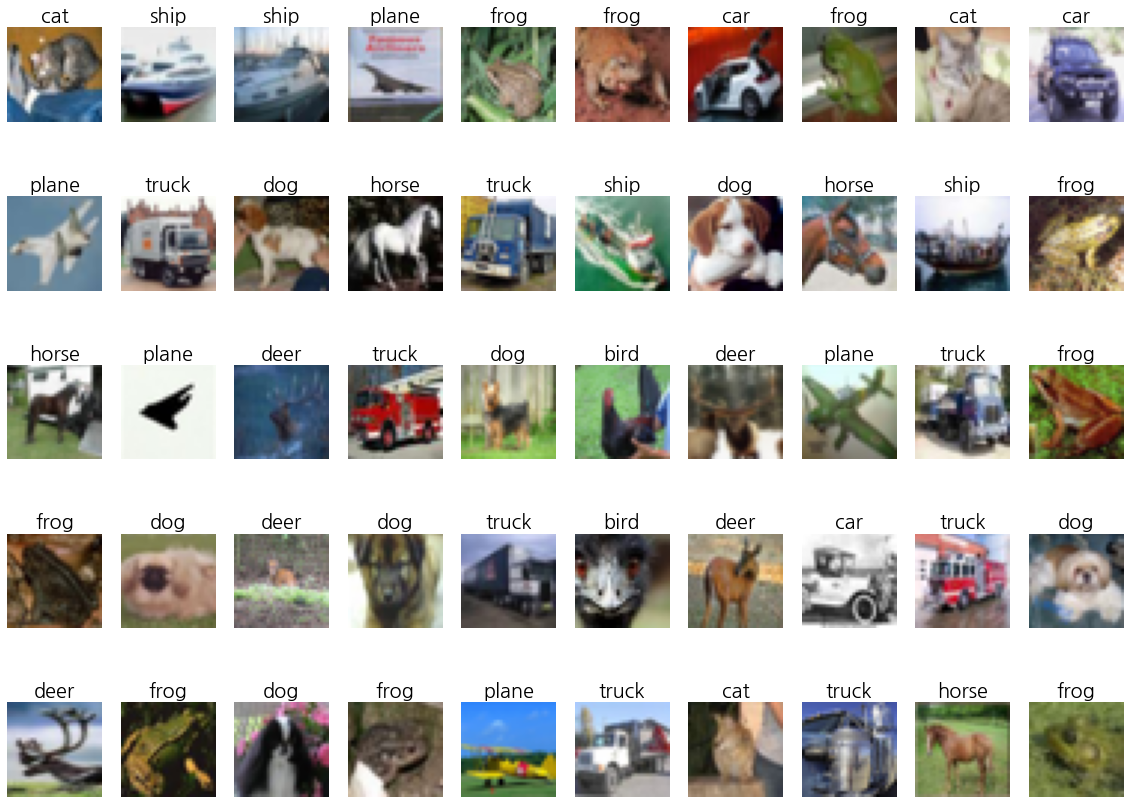

In [28]:
# 정답 라벨 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
show_images_labels(test_loader2, classes, None, None)

## 9.7 모델 정의(전결합형)

### 학습용 파라미터 설정

In [29]:
# 입력 차원수는 3*32*32=3072
n_input = image1.view(-1).shape[0]

# 출력 차원수
# 분류 클래스의 수이므로　10
n_output = len(set(list(labels1.data.numpy())))

# 은닉층의 노드수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [30]:
# 모델 정의
# 3072입력 10출력 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층의 노드수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층의 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### 모델 인스턴스 생성과 GPU 할당

In [31]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [32]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [33]:
# 모델 개요 표시 2

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

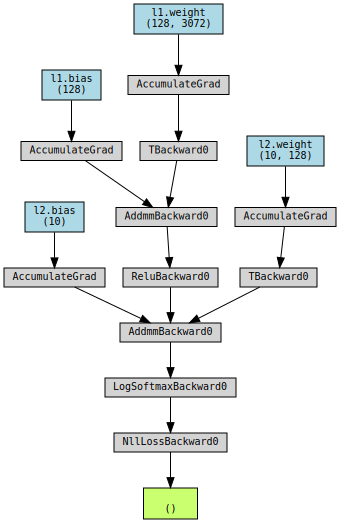

In [34]:
# 손실 계산
loss = eval_loss(test_loader1, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.8 결과(전결합형)

### 학습

In [35]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32202 val_loss: 0.01794, val_acc: 0.37690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39568 val_loss: 0.01684, val_acc: 0.41740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42412 val_loss: 0.01622, val_acc: 0.43760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44230 val_loss: 0.01583, val_acc: 0.45060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45544 val_loss: 0.01553, val_acc: 0.46170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46814 val_loss: 0.01530, val_acc: 0.46810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47696 val_loss: 0.01512, val_acc: 0.47440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48628 val_loss: 0.01493, val_acc: 0.47790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49592 val_loss: 0.01480, val_acc: 0.48650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50398 val_loss: 0.01463, val_acc: 0.48910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51106 val_loss: 0.01450, val_acc: 0.49680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52020 val_loss: 0.01437, val_acc: 0.50230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52662 val_loss: 0.01425, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53482 val_loss: 0.01423, val_acc: 0.50530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53934 val_loss: 0.01408, val_acc: 0.51240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54576 val_loss: 0.01402, val_acc: 0.51130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55166 val_loss: 0.01391, val_acc: 0.51500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55666 val_loss: 0.01388, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56156 val_loss: 0.01379, val_acc: 0.52050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56668 val_loss: 0.01381, val_acc: 0.51680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57088 val_loss: 0.01372, val_acc: 0.51780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57696 val_loss: 0.01368, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58040 val_loss: 0.01363, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58438 val_loss: 0.01356, val_acc: 0.52610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59100 val_loss: 0.01352, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01190 acc: 0.59368 val_loss: 0.01351, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59852 val_loss: 0.01350, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60162 val_loss: 0.01343, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60546 val_loss: 0.01342, val_acc: 0.52800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60900 val_loss: 0.01346, val_acc: 0.52990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61458 val_loss: 0.01340, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61740 val_loss: 0.01338, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62126 val_loss: 0.01339, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62528 val_loss: 0.01342, val_acc: 0.52690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01096 acc: 0.62896 val_loss: 0.01341, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63172 val_loss: 0.01334, val_acc: 0.53230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63530 val_loss: 0.01340, val_acc: 0.52760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63980 val_loss: 0.01336, val_acc: 0.53130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64160 val_loss: 0.01342, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01051 acc: 0.64504 val_loss: 0.01349, val_acc: 0.52360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64950 val_loss: 0.01341, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65080 val_loss: 0.01347, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65280 val_loss: 0.01347, val_acc: 0.52400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65628 val_loss: 0.01346, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65990 val_loss: 0.01345, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66234 val_loss: 0.01345, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66492 val_loss: 0.01349, val_acc: 0.52540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00984 acc: 0.66784 val_loss: 0.01352, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67024 val_loss: 0.01364, val_acc: 0.51850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67194 val_loss: 0.01354, val_acc: 0.53150


### 평가

초기상태 : 손실 : 0.01794  정확도 : 0.37690
최종상태 : 손실 : 0.01354  정확도 : 0.53150


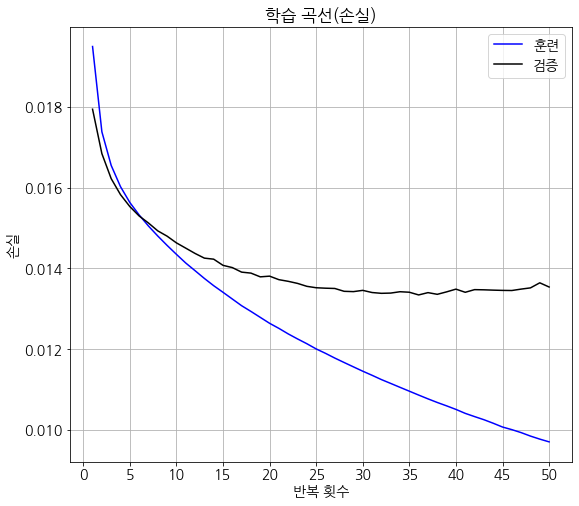

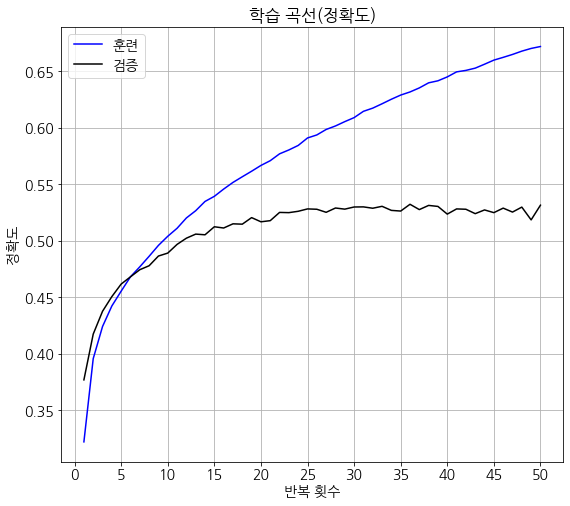

In [36]:
# 평가

evaluate_history(history)

## 9.9 모델 정의(CNN)

In [37]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### 모델 인스턴스 생성

In [38]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [39]:
# 모델 개요 표시 1

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [40]:
# 모델 개요 표시2

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable pa

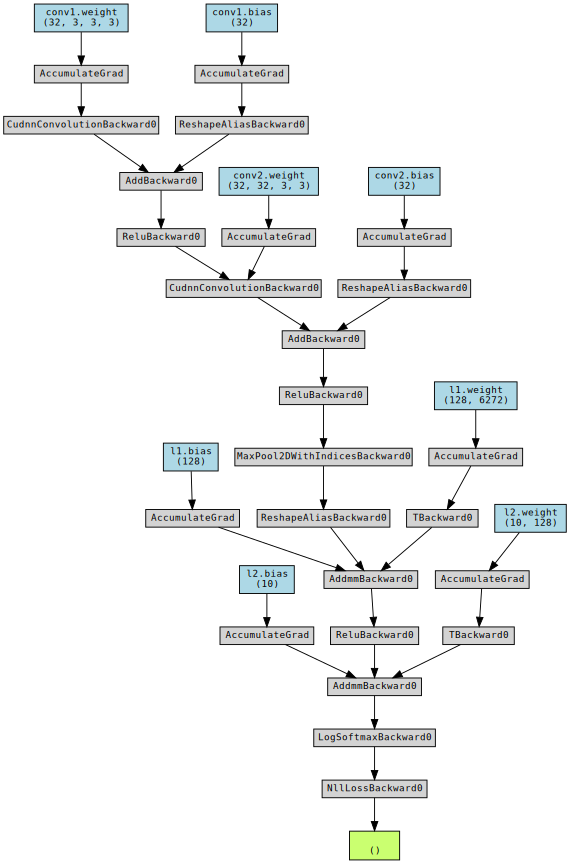

In [48]:
# 손실 계산
loss = eval_loss(test_loader2, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 결과(CNN)

### 학습

In [49]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history2 = np.zeros((0,5))

# 학습
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26088 val_loss: 0.01866, val_acc: 0.34660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37338 val_loss: 0.01677, val_acc: 0.40910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43060 val_loss: 0.01531, val_acc: 0.45950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47302 val_loss: 0.01449, val_acc: 0.48810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49914 val_loss: 0.01370, val_acc: 0.51240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52134 val_loss: 0.01332, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01304 acc: 0.53748 val_loss: 0.01291, val_acc: 0.53900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01253 acc: 0.55458 val_loss: 0.01253, val_acc: 0.55180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57306 val_loss: 0.01235, val_acc: 0.56040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59164 val_loss: 0.01184, val_acc: 0.58090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01117 acc: 0.60830 val_loss: 0.01164, val_acc: 0.58950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62376 val_loss: 0.01173, val_acc: 0.58350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01037 acc: 0.63576 val_loss: 0.01109, val_acc: 0.60640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00999 acc: 0.64990 val_loss: 0.01090, val_acc: 0.61230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00960 acc: 0.66424 val_loss: 0.01114, val_acc: 0.60310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00924 acc: 0.67610 val_loss: 0.01055, val_acc: 0.63100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00883 acc: 0.69248 val_loss: 0.01071, val_acc: 0.62360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00848 acc: 0.70330 val_loss: 0.01013, val_acc: 0.64670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00810 acc: 0.71890 val_loss: 0.01018, val_acc: 0.64030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00775 acc: 0.73184 val_loss: 0.01045, val_acc: 0.63440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00740 acc: 0.74266 val_loss: 0.01000, val_acc: 0.65480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00703 acc: 0.75788 val_loss: 0.01022, val_acc: 0.65330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00675 acc: 0.76676 val_loss: 0.00994, val_acc: 0.65860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00639 acc: 0.78098 val_loss: 0.01007, val_acc: 0.65970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00606 acc: 0.79176 val_loss: 0.00997, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00571 acc: 0.80430 val_loss: 0.01053, val_acc: 0.64740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00542 acc: 0.81400 val_loss: 0.01063, val_acc: 0.65730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00510 acc: 0.82752 val_loss: 0.01100, val_acc: 0.64730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00475 acc: 0.83970 val_loss: 0.01060, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00444 acc: 0.85178 val_loss: 0.01109, val_acc: 0.65690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00411 acc: 0.86260 val_loss: 0.01094, val_acc: 0.66600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00382 acc: 0.87168 val_loss: 0.01157, val_acc: 0.65560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00354 acc: 0.88276 val_loss: 0.01115, val_acc: 0.66890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00325 acc: 0.89264 val_loss: 0.01245, val_acc: 0.64720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00296 acc: 0.90482 val_loss: 0.01278, val_acc: 0.64890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00271 acc: 0.91388 val_loss: 0.01281, val_acc: 0.65420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00241 acc: 0.92492 val_loss: 0.01276, val_acc: 0.66520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00219 acc: 0.93114 val_loss: 0.01335, val_acc: 0.65860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00196 acc: 0.94054 val_loss: 0.01404, val_acc: 0.65400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00174 acc: 0.95028 val_loss: 0.01432, val_acc: 0.65450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00147 acc: 0.95906 val_loss: 0.01487, val_acc: 0.65580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00136 acc: 0.96324 val_loss: 0.01531, val_acc: 0.65310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00109 acc: 0.97350 val_loss: 0.01664, val_acc: 0.64560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00093 acc: 0.97874 val_loss: 0.01610, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00082 acc: 0.98254 val_loss: 0.01654, val_acc: 0.66010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00064 acc: 0.98924 val_loss: 0.01702, val_acc: 0.65660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00046 acc: 0.99464 val_loss: 0.01745, val_acc: 0.66380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00037 acc: 0.99656 val_loss: 0.01802, val_acc: 0.66230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99780 val_loss: 0.01861, val_acc: 0.66540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00025 acc: 0.99854 val_loss: 0.01912, val_acc: 0.65970


### 평가

초기상태 : 손실 : 0.01866  정확도 : 0.34660
최종상태 : 손실 : 0.01912  정확도 : 0.65970


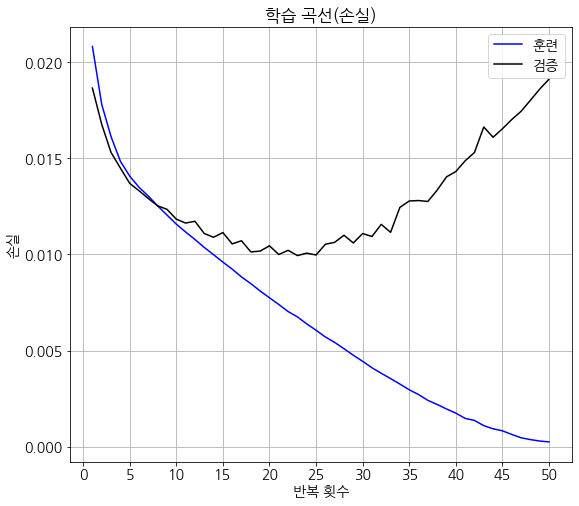

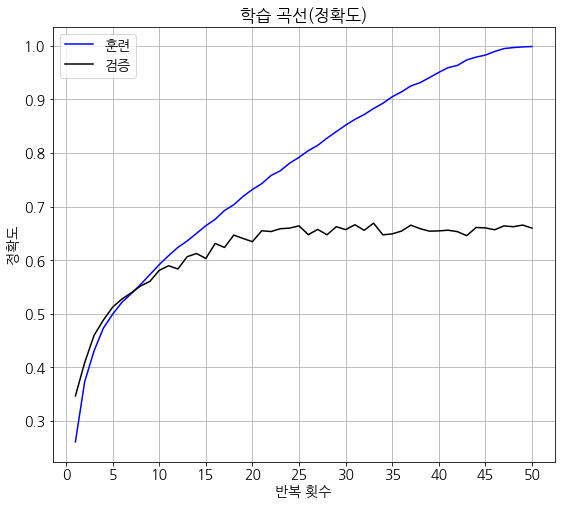

In [50]:
# 평가

evaluate_history(history2)

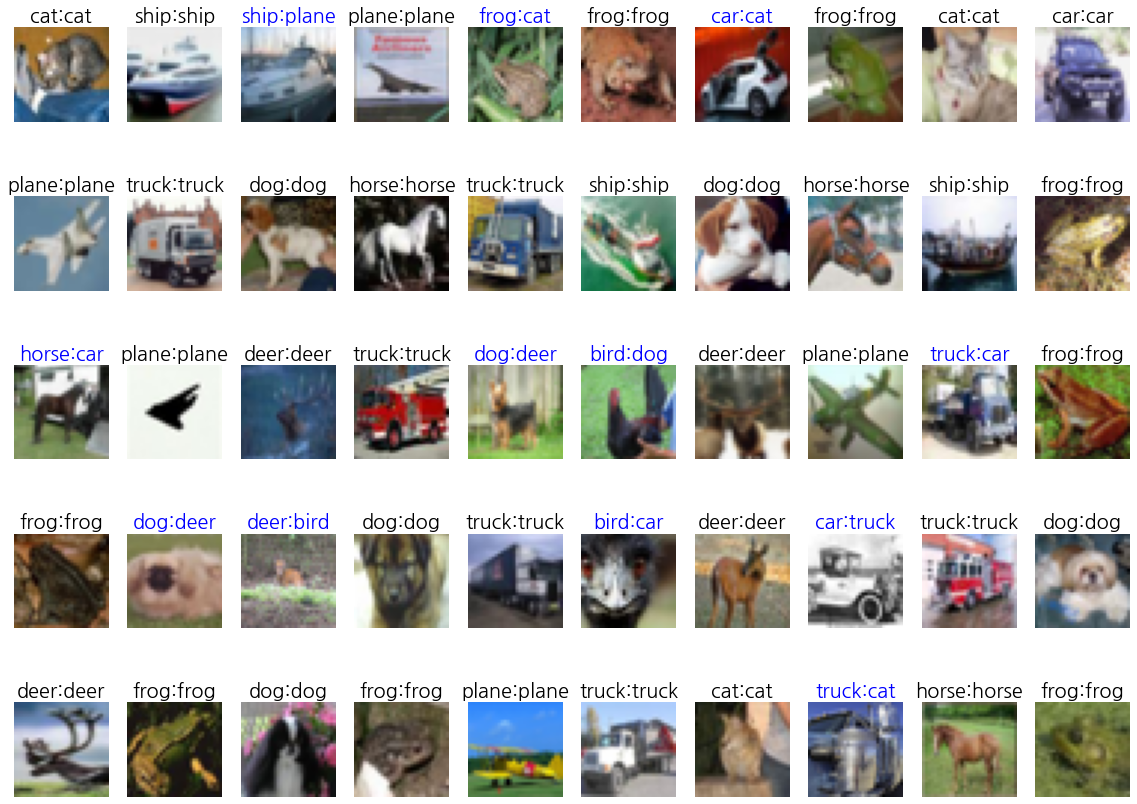

In [51]:
# 처음 50개 데이터 표시

show_images_labels(test_loader2, classes, net, device)